In [1]:
library(tidyverse)
library(DESeq2)
library(BiocParallel)
library(RColorBrewer)
library(pheatmap)
library(umap)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects

In [2]:
n_cores <- detectCores() - 2
BiocParallel::register(MulticoreParam(n_cores))

In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
gyn_projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
nongyn_projects <- c("TCGA-BRCA", "TCGA-COAD", "TCGA-LGG")
pan_projects <- c(gyn_projects, nongyn_projects)

# Load data

In [4]:
pan_coldata_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/matrisome_pan_coldata.tsv"))
pan_counts_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/prefiltered_norm_matrisome_pan_counts.tsv")) %>%
    dplyr::select(-ensembl_gene_id)

Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)
Parsed with column specification:
cols(
  .default = col_double(),
  ensembl_gene_id = col_character(),
  external_gene_name = col_character()
)
See spec(...) for full column specifications.


In [5]:
gyn_coldata_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/matrisome_gyn_coldata.tsv"))
gyn_counts_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/prefiltered_norm_matrisome_gyn_counts.tsv")) %>%
    dplyr::select(-ensembl_gene_id)

Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)
Parsed with column specification:
cols(
  .default = col_double(),
  ensembl_gene_id = col_character(),
  external_gene_name = col_character()
)
See spec(...) for full column specifications.


In [34]:
get_pca_results <- function(counts, coldata_df) {
    pca_res <- prcomp(t(counts), center = TRUE, scale. = FALSE)
    
    pca_res_df <- pca_res$x %>%
        as_tibble(rownames = "sample_name") %>%
        mutate(project = coldata_df$project) %>%
        dplyr::select(sample_name, project, everything())
    
    pca_var_df <- tibble(pc = colnames(pca_res$x)) %>%
        mutate(var = pca_res$sdev ^ 2) %>%
        mutate(pct_var = round(var / sum(var) * 100, 1)) %>%
        mutate(pc_fact = factor(colnames(pca_res$x), levels = colnames(pca_res$x)))
    
    return(list(
        res = pca_res_df,
        var = pca_var_df
    ))
}

get_umap_results <- function(counts, coldata_df, random_state) {
    res_umap <- umap(t(counts), random_state = random_state)
    
    colnames(res_umap$layout) <- c("x1", "x2")
    umap_df <- res_umap$layout %>%
        as_tibble() %>%
        bind_cols(coldata_df)
    return(umap_df)
}

pca_scatter <- function(df, pc_x, pc_y, pc_x_pctvar, pc_y_pctvar, col) {
    plt <- ggplot(df) +
        aes_string(x = pc_x, y = pc_y, color = col) +
        geom_point(size=0.5) +
        xlab(paste0(pc_x, " (", pc_x_pctvar, "%)")) + 
        ylab(paste0(pc_y, " (", pc_y_pctvar, "%)")) +
        coord_fixed()
    return(plt)
}

plot_hm <- function(hm, dest) {
    png(dest)
    grid::grid.newpage()
    grid::grid.draw(hm$gtable)
    dev.off()
}

# Heatmaps

## Get representative group samples

In [8]:
gyn_centroids <- get_group_centroids(
    gyn_counts_df, gyn_coldata_df, gyn_projects, "project", "sample_name"
)

pan_centroids <- get_group_centroids(
    pan_counts_df, pan_coldata_df, pan_projects, "project", "sample_name"
)

In [9]:
gyn_hm_meta_df <- balanced_group_sample(
    gyn_counts_df,
    gyn_coldata_df,
    gyn_centroids,
    gyn_projects,
    n = 10,
    "project",
    "sample_name"
)

pan_hm_meta_df <- balanced_group_sample(
    pan_counts_df,
    pan_coldata_df,
    pan_centroids,
    pan_projects,
    n = 10,
    "project",
    "sample_name"
)

# Get data needed for heatmaps

In [10]:
gyn_hm_ls <- get_hm_dfs(gyn_counts_df, gyn_coldata_df, gyn_hm_meta_df)

pan_hm_ls <- get_hm_dfs(pan_counts_df, pan_coldata_df, pan_hm_meta_df)

In [11]:
gyn_clusts <- get_hm_clusters(gyn_hm_ls$counts)
gyn_zscores <- t(apply(gyn_hm_ls$counts, 1, rutils::get_z_score))

pan_clusts <- get_hm_clusters(pan_hm_ls$counts)
pan_zscores <- t(apply(pan_hm_ls$counts, 1, rutils::get_z_score))

In [12]:
gyn_proj_colors <- list(project = brewer.pal(n = length(gyn_projects), name = "Set1"))
names(gyn_proj_colors$project) <- unique(gyn_hm_ls$coldata$project)

pan_proj_colors <- list(project = brewer.pal(n = length(pan_projects), name = "Set2"))
names(pan_proj_colors$project) <- unique(pan_hm_ls$coldata$project)

png 
  2

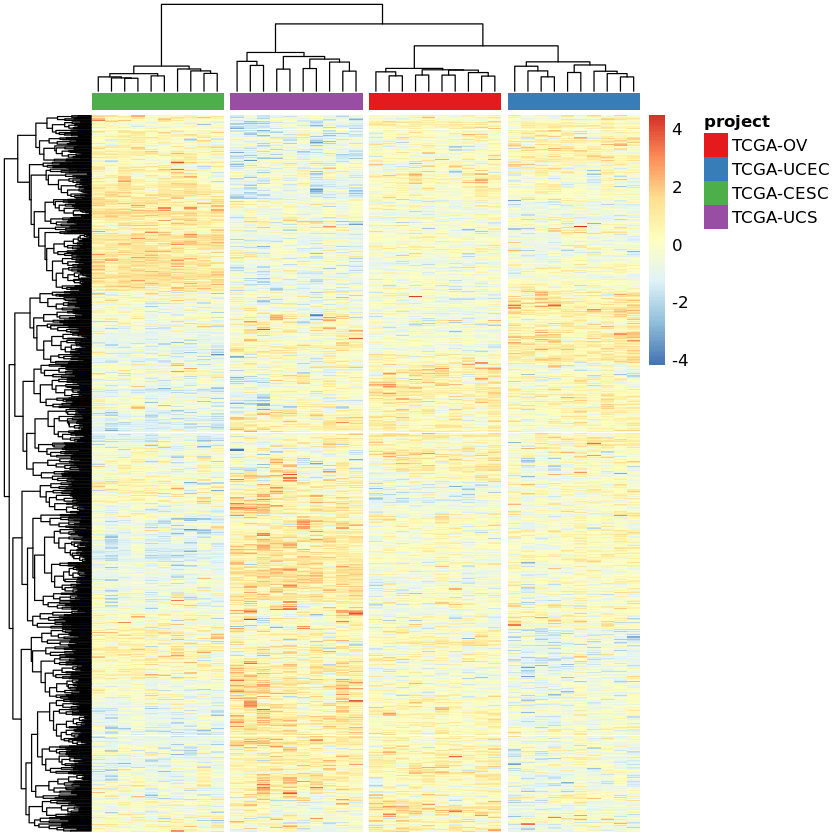

png 
  2

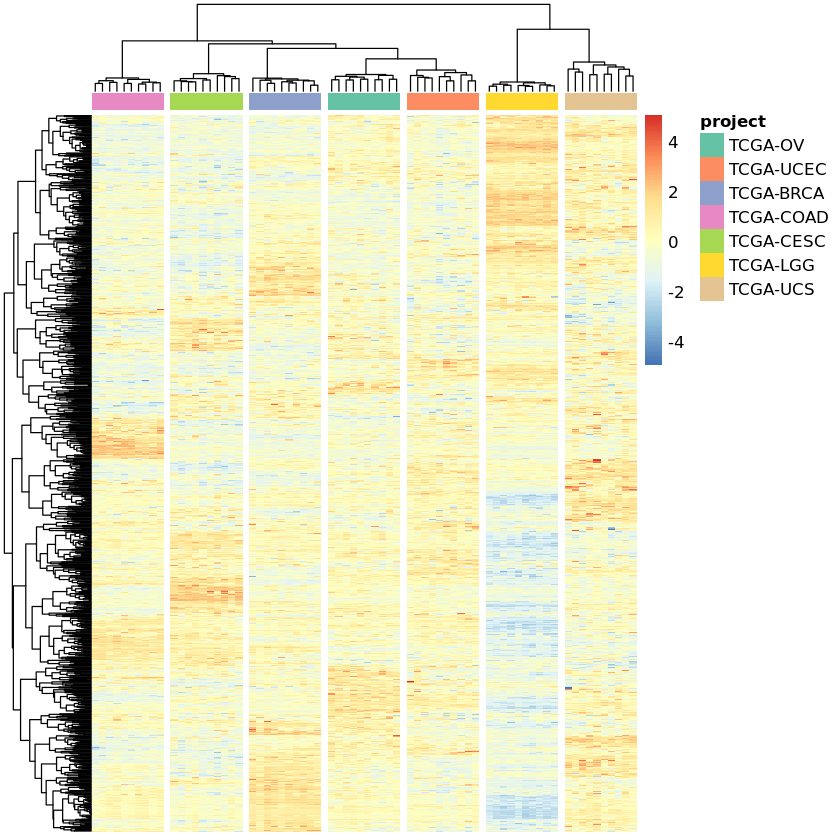

In [13]:
gyn_hm <- pheatmap(
    gyn_zscores,
    cluster_rows = gyn_clusts$row,
    cluster_cols = gyn_clusts$col,
    cutree_cols = length(gyn_projects),
    show_rownames = FALSE,
    show_colnames = FALSE,
    annotation_col = gyn_hm_ls$coldata["project"],
    annotation_names_col = FALSE,
    annotation_colors = gyn_proj_colors
)
plot_hm(gyn_hm, paste0(dirs$figures_dir, "/gyn_heatmap.png"))

pan_hm <- pheatmap(
    pan_zscores,
    cluster_rows = pan_clusts$row,
    cluster_cols = pan_clusts$col,
    cutree_cols = length(pan_projects),
    show_rownames = FALSE,
    show_colnames = FALSE,
    annotation_col = pan_hm_ls$coldata["project"],
    annotation_names_col = FALSE,
    annotation_colors = pan_proj_colors
)
plot_hm(pan_hm, paste0(dirs$figures_dir, "/pan_heatmap.png"))

# PCA

In [22]:
pan_pca_ls <- get_pca_results(pan_counts_df[, -1], pan_coldata_df)

Saving 6.67 x 6.67 in image


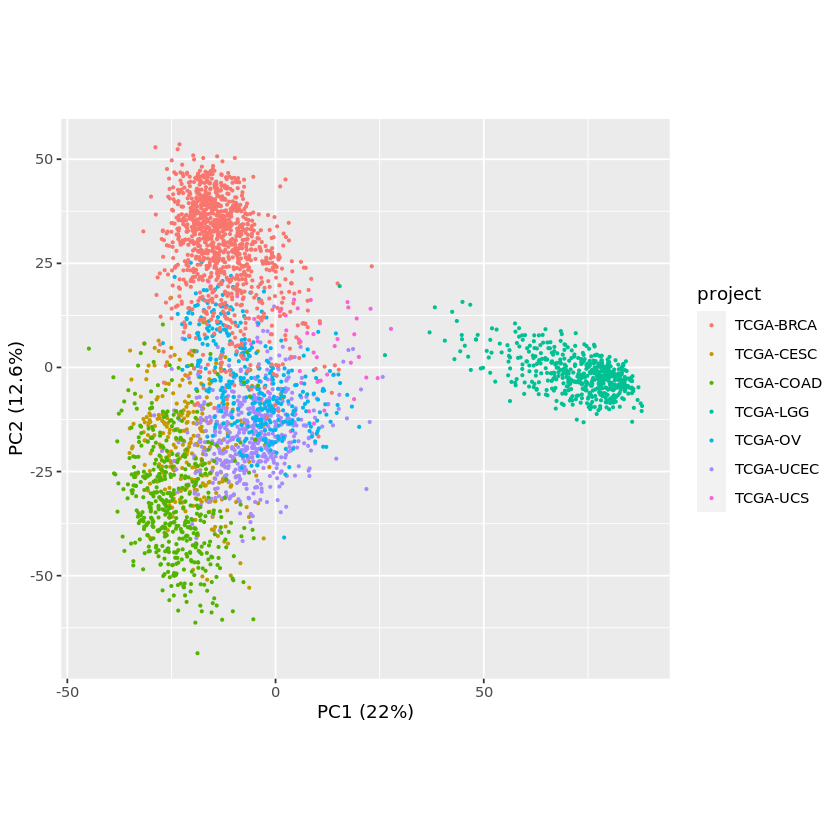

Saving 6.67 x 6.67 in image


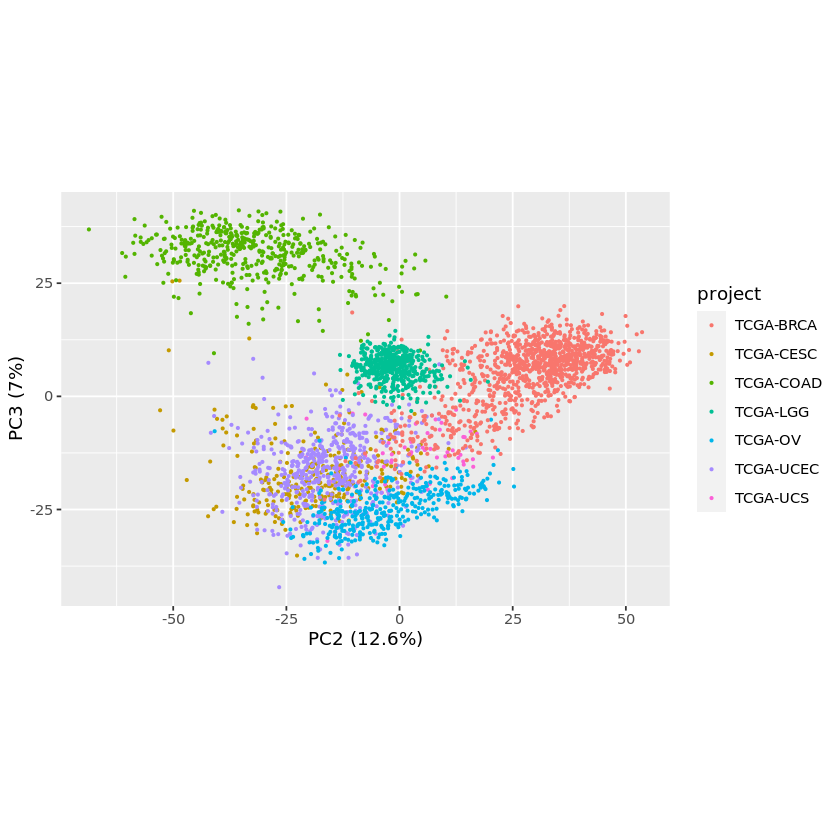

In [26]:
pca_scatter(pan_pca_ls$res, "PC1", "PC2", pan_pca_ls$var[1, ]$pct_var, pan_pca_ls$var[2, ]$pct_var, "project")
ggsave(filename = paste0(dirs$figures_dir, "/pan_PC2_vs_PC1.png"), last_plot())
pca_scatter(pan_pca_ls$res, "PC2", "PC3", pan_pca_ls$var[2, ]$pct_var, pan_pca_ls$var[3, ]$pct_var, "project")
ggsave(filename = paste0(dirs$figures_dir, "/pan_PC3_vs_PC2.png"), last_plot())

In [18]:
pan_pca_pivot_df <- pan_pca_ls$res %>%
    dplyr::select(sample_name, PC1:PC4, project) %>%
    pivot_longer(cols = PC1:PC4, names_to = "PC", values_to = "loadings") %>%
    mutate(proj_id = as.numeric(as.factor(project)))

head(pan_pca_pivot_df)

sample_name,project,PC,loadings,proj_id
<chr>,<chr>,<chr>,<dbl>,<dbl>
TCGA-MY-A5BF-01A-11R-A26T-07,TCGA-CESC,PC1,-17.76688,2
TCGA-MY-A5BF-01A-11R-A26T-07,TCGA-CESC,PC2,-22.00435,2
TCGA-MY-A5BF-01A-11R-A26T-07,TCGA-CESC,PC3,-21.68625,2
TCGA-MY-A5BF-01A-11R-A26T-07,TCGA-CESC,PC4,54.03638,2
TCGA-EA-A3HU-01A-11R-A213-07,TCGA-CESC,PC1,-18.52454,2
TCGA-EA-A3HU-01A-11R-A213-07,TCGA-CESC,PC2,-16.38821,2


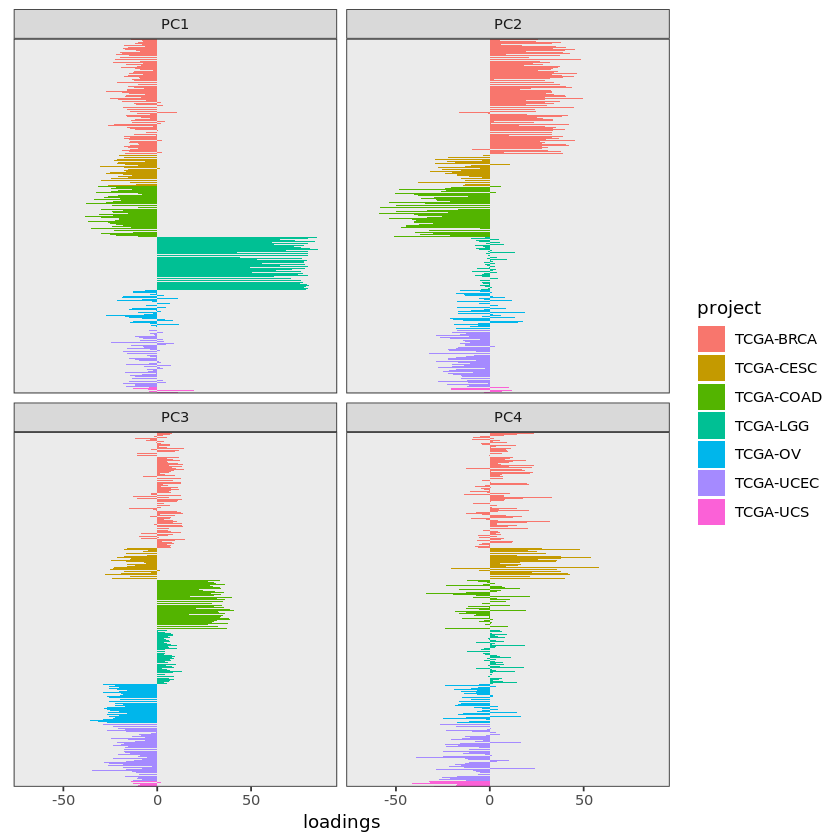

In [20]:
ggplot(pan_pca_pivot_df) +
    aes(x=reorder(sample_name, -proj_id), y=loadings, fill=project) +
    geom_bar(stat="identity") +
    facet_wrap(~PC) +
    coord_flip() +
    theme_bw() + 
    theme(
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank()
    )

# UMAP

In [35]:
pan_umap_df <- get_umap_results(pan_counts_df[, -1], pan_coldata_df, random_state = 10)

In [36]:
pan_umap_plt <- ggplot(pan_umap_df) +
    aes(x = x1, y = x2, color = project) +
    geom_point(size=0.5) +
    guides(color = guide_legend(override.aes = list(size = length(unique(pan_umap_df$project))))) +
    theme(legend.key = element_rect(fill = NA, color = NA))
ggsave(filename = paste0(dirs$figures_dir, "/pan_umap.png"), last_plot())

Saving 6.67 x 6.67 in image


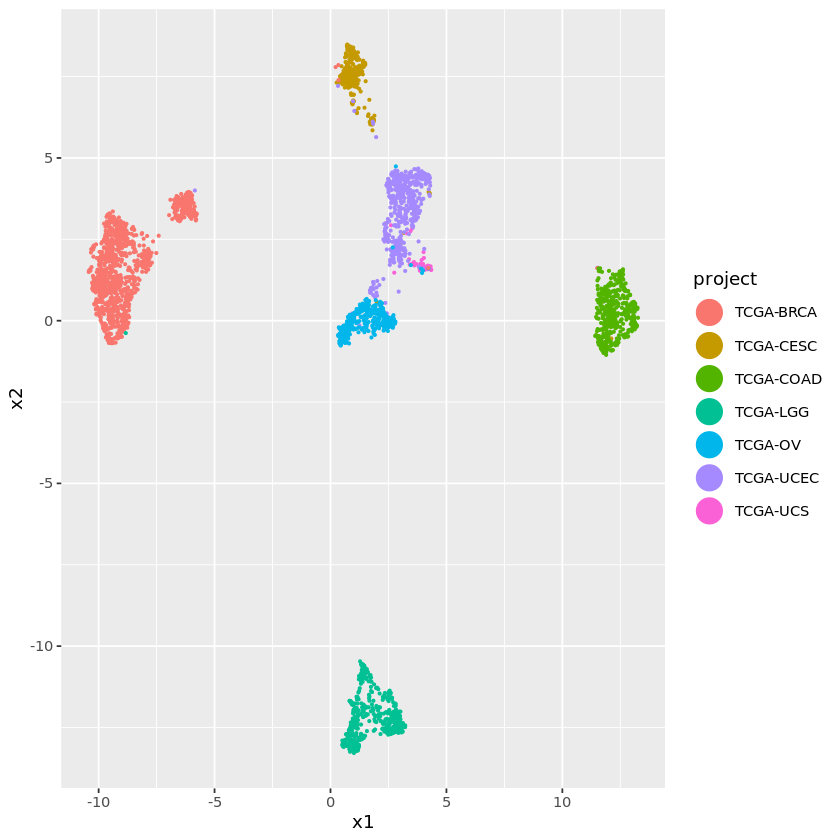

In [37]:
pan_umap_plt